# Packages

In [1]:
!pip install pfhedge


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/julesarzel/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io

In [2]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import BlackScholes
from pfhedge.nn import Clamp
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron
from pfhedge.nn import EntropicRiskMeasure
from pfhedge.nn import Hedger

# Option characteristics

In [3]:
stock = BrownianStock(cost=1e-4)
derivative = EuropeanOption(stock, maturity=1)

derivative

EuropeanOption(
  strike=1., maturity=1
  (underlier): BrownianStock(sigma=0.2000, cost=1.0000e-04, dt=0.0040)
)

# Alternative Network Architecture

In [4]:
class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)


# Training and Pricing with the MLP

In [ ]:
torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model_MLP = MultiLayerPerceptron()
hedger_MLP = Hedger(model_MLP, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger_MLP.fit(derivative, n_paths=10000, n_epochs=200)
price_MLP = hedger_MLP.price(derivative, n_paths=10000)
print(f"Price={price_MLP:.5e}")

Loss=0.0915: 100%|██████████| 200/200 [12:23<00:00,  3.72s/it]


Price=8.67643e-02


# Training and Pricing with the NTBN

In [ ]:
torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model_NTBN = NoTransactionBandNet(derivative)
hedger_NTBN = Hedger(model_NTBN, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

# Fit and price
hedger_NTBN.fit(derivative, n_paths=10000, n_epochs=200)
price_NTBN = hedger_NTBN.price(derivative, n_paths=10000)
print(f"Price={price_NTBN:.5e}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.0800: 100%|██████████| 200/200 [14:42<00:00,  4.41s/it]


Price=7.98159e-02


# Training of both networks for several different cost levels 

In [27]:
import numpy as np
for i in range(11):
    print(f'exp de {-i}={np.exp(-i)}')

exp de 0=1.0
exp de -1=0.36787944117144233
exp de -2=0.1353352832366127
exp de -3=0.049787068367863944
exp de -4=0.01831563888873418
exp de -5=0.006737946999085467
exp de -6=0.0024787521766663585
exp de -7=0.0009118819655545162
exp de -8=0.00033546262790251185
exp de -9=0.00012340980408667956
exp de -10=4.5399929762484854e-05


In [47]:
for i in range(2,11):
    globals()[f'derivative_{i}'] = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)
    globals()[f'model_MLP_{i}'] = MultiLayerPerceptron()
    globals()[f'model_NTBN_{i}'] = NoTransactionBandNet(globals()[f'derivative_{i}'])
    globals()[f'hedger_MLP_{i}'] = Hedger(globals()[f'model_MLP_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_NTBN_{i}'] = Hedger(globals()[f'model_NTBN_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_MLP_{i}'].fit(globals()[f'derivative_{i}'], n_paths=10000, n_epochs=100)
    globals()[f'hedger_NTBN_{i}'].fit(globals()[f'derivative_{i}'], n_paths=10000, n_epochs=100)
    globals()[f'price_MLP_{i}'] = globals()[f'hedger_MLP_{i}'].price(derivative, n_paths=10000)
    globals()[f'price_NTBN_{i}'] = globals()[f'hedger_NTBN_{i}'].price(derivative, n_paths=10000)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.0947:   1%|          | 1/100 [00:06<10:18,  6.25s/it]


KeyboardInterrupt: 

In [ ]:
'''from collections import defaultdict

derivatives = {}
models_MLP = {}
models_NTBN = {}
hedgers_MLP = {}
hedgers_NTBN = {}
prices_MLP = {}
prices_NTBN = {}

for i in range(2, 11):
    derivative = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)
    model_mlp = MultiLayerPerceptron()
    model_ntbn = NoTransactionBandNet(derivative)

    hedger_mlp = Hedger(model_mlp, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    hedger_ntbn = Hedger(model_ntbn, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])

    hedger_mlp.fit(derivative, n_paths=10000, n_epochs=200)
    hedger_ntbn.fit(derivative, n_paths=10000, n_epochs=200)

    # Save to dictionaries
    derivatives[i] = derivative
    models_MLP[i] = model_mlp
    models_NTBN[i] = model_ntbn
    hedgers_MLP[i] = hedger_mlp
    hedgers_NTBN[i] = hedger_ntbn

    prices_MLP[i] = hedger_mlp.price(derivative, n_paths=10000)
    prices_NTBN[i] = hedger_ntbn.price(derivative, n_paths=10000)
    
    for i in range(2, 11):
    print(f"Cost: {np.exp(-i):.4f} | MLP Price: {prices_MLP[i]:.4f} | NTBN Price: {prices_NTBN[i]:.4f}")'''

In [19]:
derivative_0 = EuropeanOption(BrownianStock(cost=0), maturity=1)
model_MLP_0 = MultiLayerPerceptron()
hedger_MLP_0 = Hedger(model_MLP_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
hedger_MLP_0.fit(derivative_0, n_paths=10000, n_epochs=100)
model_NTBN_0 = NoTransactionBandNet(derivative_0)
hedger_NTBN_0 = Hedger(model_NTBN_0, ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
hedger_NTBN_0.fit(derivative_0, n_paths=10000, n_epochs=100)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loss=0.0807: 100%|██████████| 100/100 [04:20<00:00,  2.60s/it]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.0797: 100%|

[0.0796213150024414,
 0.07972145080566406,
 0.07967376708984375,
 0.07965469360351562,
 0.07976055145263672,
 0.07972908020019531,
 0.07966995239257812,
 0.07964611053466797,
 0.07955360412597656,
 0.07962322235107422,
 0.07975101470947266,
 0.07967090606689453,
 0.07976055145263672,
 0.07969379425048828,
 0.07963752746582031,
 0.07977676391601562,
 0.07962989807128906,
 0.07973384857177734,
 0.07966995239257812,
 0.07973766326904297,
 0.079742431640625,
 0.07970905303955078,
 0.07968521118164062,
 0.07977867126464844,
 0.07966899871826172,
 0.07959747314453125,
 0.07971668243408203,
 0.07965373992919922,
 0.07958984375,
 0.07961273193359375,
 0.07954978942871094,
 0.0797271728515625,
 0.07965469360351562,
 0.07967185974121094,
 0.07964801788330078,
 0.07967376708984375,
 0.0796651840209961,
 0.07966899871826172,
 0.07968521118164062,
 0.07970333099365234,
 0.07962608337402344,
 0.07964515686035156,
 0.07965469360351562,
 0.07965087890625,
 0.07960224151611328,
 0.07969856262207031,
 0

In [6]:
for i in range(2,11):
    globals()[f'derivative_{i}'] = EuropeanOption(BrownianStock(cost=np.exp(-i)), maturity=1)
    globals()[f'model_MLP_{i}'] = MultiLayerPerceptron()
    globals()[f'model_NTBN_{i}'] = NoTransactionBandNet(globals()[f'derivative_{i}'])
    globals()[f'hedger_MLP_{i}'] = Hedger(globals()[f'model_MLP_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_NTBN_{i}'] = Hedger(globals()[f'model_NTBN_{i}'], ["log_moneyness", "expiry_time", "volatility", "prev_hedge"])
    globals()[f'hedger_MLP_{i}'].load_state_dict(torch.load(f'MLP_{i}.pth'))
    globals()[f'hedger_NTBN_{i}'].load_state_dict(torch.load(f'NTBN_{i}.pth'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
price_MLP = []
price_NTBN = []
for i in range(2,11):
    globals()[f'hedger_MLP_{i}'].eval()
    globals()[f'hedger_NTBN_{i}'].eval()
    price_MLP.append(eval(f'hedger_MLP_{i}').price(derivative, n_paths=10000, n_times = 10).item())
    price_NTBN.append(eval(f'hedger_MLP_{i}').price(derivative, n_paths=10000, n_times = 10).item())


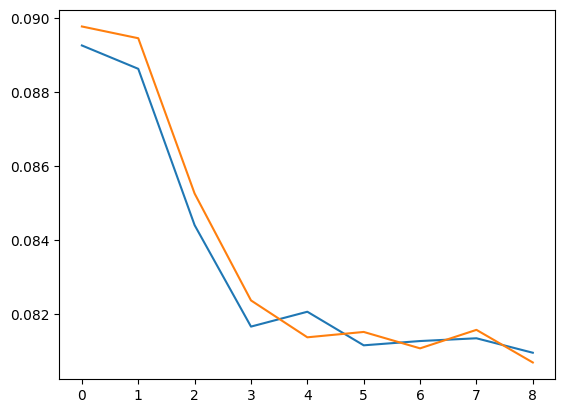

In [17]:
plt.plot(price_MLP)
plt.plot(price_NTBN)
plt.show()

In [ ]:
price_MLP_0 = hedger_MLP_0.price(derivative_0, n_paths=10000, n_times=100).item()
price_NTBN_0 = hedger_NTBN_0.price(derivative_0, n_paths=10000, n_times=100).item()

TypeError: unsupported operand type(s) for -: 'list' and 'float'

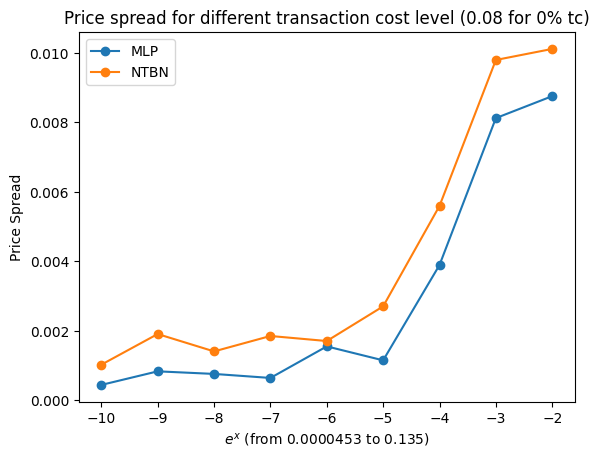

In [36]:
price_spread_MLP = np.array(price_MLP) - price_MLP_0
price_spread_NTBN = np.array(price_NTBN) - price_NTBN_0
plt.plot(list(range(-10, -1)),price_spread_MLP[::-1], 'o-', label='MLP')
plt.plot(list(range(-10, -1)),price_spread_NTBN[::-1], 'o-', label='NTBN')
plt.ylabel('Price Spread')
plt.xlabel(r'$e^x$ (from 0.0000453 to 0.135)')
plt.title('Price spread for different transaction cost level (0.08 for 0% tc)')
plt.legend()
plt.show()